# Tests on the W operator

Check that the W operator is build correctly
W d = s - inv(B^t invN B) Bt invN d

In [3]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from fgbuster.observation_helpers import get_instrument, standardize_instrument, get_observation
from micmac import *

#### Get some input frequency maps and CMB only maps

In [4]:
# General parameters
NSIDE = 64
cmb_model = 'c1'
synch_model = 's0'
dust_model = 'd0'
fgs_model = synch_model+dust_model
model = cmb_model+fgs_model

instr_name = 'LiteBIRD'
# get instrument from public database
instr_ = get_instrument(instr_name)
instrument = standardize_instrument(instr_)

# get input freq maps
input_freq_maps = get_observation(instrument, model, nside=NSIDE, noise=False)

# get input cmb
input_cmb_maps = get_observation(instrument, cmb_model, nside=NSIDE, noise=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


#### 1. Get Mixing Matrix with initial values from the scaling laws (1 and 0 in the special freqs)

In [5]:
ncomp = 3
pos_special_freqs = np.array([0, -1])

In [6]:
initB = InitMixingMatrix(instrument.frequency, ncomp, pos_special_freqs)
init_params = initB.init_params()

B = MixingMatrix(instrument.frequency, ncomp, init_params, pos_special_freqs)
B_all = B.get_B()

In [7]:
print(B_all)
print(B_all.shape)

[[1.         1.         0.        ]
 [1.         0.52387813 0.00182426]
 [1.         0.3117258  0.00324908]
 [1.         0.21971687 0.00433627]
 [1.         0.15096497 0.0057459 ]
 [1.         0.10631274 0.0074421 ]
 [1.         0.07881344 0.00935487]
 [1.         0.05159725 0.0133358 ]
 [1.         0.03585547 0.01906532]
 [1.         0.02552178 0.02888587]
 [1.         0.0193825  0.04508262]
 [1.         0.01493871 0.08217483]
 [1.         0.01211497 0.16061503]
 [1.         0.00871575 0.37616284]
 [1.         0.         1.        ]]
(15, 3)


#### 1. Build Wd

In [8]:
invN = get_noise_covar(instrument.depth_p, NSIDE)

In [9]:
recovered_CMB = get_Wd(invN, B_all, input_freq_maps[:, 1:, :], jax_use=False)[0, :, :]
residuals_CMB = recovered_CMB - input_cmb_maps[0, 1:, :]

recovered_CMB_all = np.concatenate((np.zeros((1, 12*NSIDE**2)), recovered_CMB), axis=0)
residuals_CMB_all = np.concatenate((np.zeros((1, 12*NSIDE**2)), residuals_CMB), axis=0)

#### 1. Plot spectra of input cmb vs recovered cmb

In [10]:
lmin = 2
lmax = 3*NSIDE
ell = np.arange(lmin, lmax + 1, 1)

In [11]:
input_cmb_ps = hp.anafast(input_cmb_maps[0], lmax=lmax, pol=True)[:, lmin:]

In [12]:
recovered_CMB_ps = hp.anafast(recovered_CMB_all, lmax=lmax, pol=True)[:, lmin:]
residuals_CMB_ps = hp.anafast(residuals_CMB_all, lmax=lmax, pol=True)[:, lmin:]

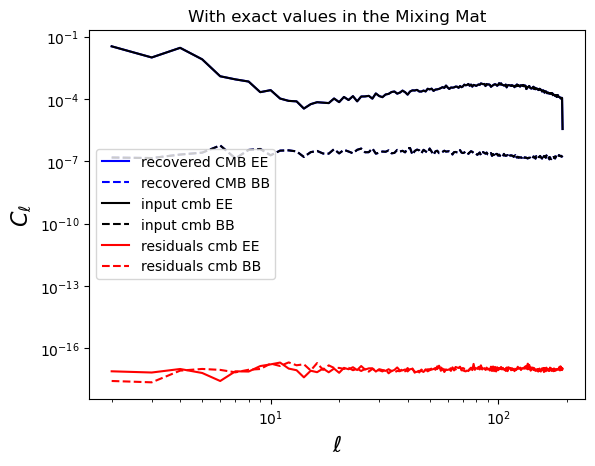

In [22]:
plt.plot(ell, recovered_CMB_ps[1], 'b', label='recovered CMB EE')
plt.plot(ell, recovered_CMB_ps[2], 'b--', label='recovered CMB BB')
plt.plot(ell, input_cmb_ps[1], 'k', label='input cmb EE')
plt.plot(ell, input_cmb_ps[2], 'k--', label='input cmb BB')
plt.plot(ell, residuals_CMB_ps[1], 'r', label='residuals cmb EE')
plt.plot(ell, residuals_CMB_ps[2], 'r--', label='residuals cmb BB')

plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$C_\ell$', fontsize=16)
plt.title('With exact values in the Mixing Mat')
plt.xscale('log')
plt.yscale('log')
plt.legend()